## We now attempt to find out if the way a SEC filing is done has an effect on the returns

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Remove warnings to keep outputs clean
warnings.filterwarnings("ignore")

PROCESSED_DATA_FOLDER = "../../data_untracked/processed"
ABNORMAL_CSV = "df_result_with_anomaly_scores_sig.csv"

COMPILED_DATA_FOLDER = "../../data_untracked/raw/sec_submissions/compiled"
FOOTNOTES_CSV = "FOOTNOTES.csv"

In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')

## Load required datasets
1. `transactions_abnormal_returns_5090_ticker.csv`: Transactions with their Cumulative Abnormal Returns (CAR)
2. `FOOTNOTES.csv`: Each transactions with their individual filing comments

In [3]:
abnormal_transactions = pd.read_csv(f'{PROCESSED_DATA_FOLDER}/{ABNORMAL_CSV}')[["ACCESSION_NUMBER", "TRANS_CODE", "TRANS_ACQUIRED_DISP_CD", "anomaly_score_30_sig", "anomaly_score_60_sig", "anomaly_score_120_sig"]]
abnormal_transactions = abnormal_transactions.rename(columns={"anomaly_score_120_sig" : "anomaly_120",
                                                               "anomaly_score_60_sig" : "anomaly_60",
                                                               "anomaly_score_30_sig" : "anomaly_30"})
footnotes = pd.read_csv(f'{COMPILED_DATA_FOLDER}/{FOOTNOTES_CSV}')
print("Loading data")

Loading data


In [4]:
print(abnormal_transactions.shape)
print(footnotes.shape)

(791687, 6)
(6453264, 3)


In [5]:
footnotes.head()

,ACCESSION_NUMBER,FOOTNOTE_ID,FOOTNOTE_TXT
0,0001179110-14-011078,F1,Sale made pursuant to a Rule 10b5-1 Plan dated...
1,0001179110-14-011078,F2,Shares adjusted for those withheld to cover ta...
2,0001144204-14-040534,F3,"Includes 2,106 shares of common stock received..."
3,0001144204-14-040534,F2,Restricted shares of common stock issued pursu...
4,0001144204-14-040534,F1,Shares issued in lieu of cash for board services.


In [6]:
df_footnote = footnotes.copy()
df_footnote = df_footnote.sort_values(by=["ACCESSION_NUMBER", "FOOTNOTE_ID"])
df_footnote["FOOTNOTE_TXT"] = df_footnote["FOOTNOTE_TXT"].astype(str)
df_grouped = df_footnote.groupby("ACCESSION_NUMBER", sort=True)["FOOTNOTE_TXT"].apply(lambda x: " ".join(x)).reset_index()
df_grouped

,ACCESSION_NUMBER,FOOTNOTE_TXT
0,0000002178-18-000032,The reporting person received a grant of 375 r...
1,0000002178-18-000042,The reporting person received a grant of 375 r...
2,0000002178-18-000043,The reporting person received a grant of 375 r...
3,0000002178-18-000044,The reporting person received a grant of 375 r...
4,0000002178-18-000045,The reporting person received a grant of 875 r...
...,...,...
2416566,0002049094-24-000001,(1)This statement is jointly filed by and on b...
2416567,0002049094-24-000002,(1) The price reported represents the weighted...
2416568,0002049094-24-000003,The price reported represents the weighted ave...
2416569,0002049094-24-000004,The price reported represents the weighted ave...


In [7]:
df_footnote_combined = pd.merge(abnormal_transactions, df_grouped, how = "left", left_on = "ACCESSION_NUMBER", right_on = "ACCESSION_NUMBER")
df_footnote_combined = df_footnote_combined[df_footnote_combined["FOOTNOTE_TXT"].notnull()]
df_footnote_combined.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,anomaly_30,anomaly_60,anomaly_120,FOOTNOTE_TXT
0,0001127602-11-000075,S,D,-4.218320,-7.700075,-12.905019,The weighted average sales price was $41.652 w...
1,0001127602-11-002229,S,D,-4.035856,-7.005213,-11.027958,This transaction was effected pursuant to a Ru...
2,0001127602-11-003431,S,D,-3.801423,-5.029422,-7.327263,This transaction was effected pursuant to a Ru...
3,0001127602-11-004376,S,D,-3.574648,-5.308864,-9.187093,This transaction was effected pursuant to a Ru...
4,0001127602-11-005631,S,D,-3.416012,-4.854250,-8.289322,This transaction was effected pursuant to a Ru...


In [8]:
df_footnote_labels = df_footnote_combined.copy()
threshold = df_footnote_labels["anomaly_120"].quantile(0.90)
df_footnote_labels["label"] = np.where(df_footnote_labels["anomaly_120"] >= threshold, 1, 0)
df_footnote_labels.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,anomaly_30,anomaly_60,anomaly_120,FOOTNOTE_TXT,label
0,0001127602-11-000075,S,D,-4.218320,-7.700075,-12.905019,The weighted average sales price was $41.652 w...,0
1,0001127602-11-002229,S,D,-4.035856,-7.005213,-11.027958,This transaction was effected pursuant to a Ru...,0
2,0001127602-11-003431,S,D,-3.801423,-5.029422,-7.327263,This transaction was effected pursuant to a Ru...,0
3,0001127602-11-004376,S,D,-3.574648,-5.308864,-9.187093,This transaction was effected pursuant to a Ru...,0
4,0001127602-11-005631,S,D,-3.416012,-4.854250,-8.289322,This transaction was effected pursuant to a Ru...,0


## We look at CAR 60 before and after. We would find the value by multiplying by 1 of its acquire and -1 if its dispose

In [9]:
df_footnote_exist_drop = df_footnote_combined.dropna(subset=["anomaly_120"]).dropna(subset=["FOOTNOTE_TXT"])
df_footnote_exist_drop.shape

(613914, 7)

In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\(.*\)", "", text)
    text = re.sub(r"[0-9,.%\$\"\(\)\/_]+", "", text)
    text = re.sub(r"(january|february|march|april|may|june|july|august|september|october|november|december)", "", text)
    
    stop_words = set(stopwords.words("english"))
    stop_words.update(["shall", "should"])
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    word_list = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] 
    
    return " ".join(word_list)

In [11]:
preprocess_text("This transaction was executed in multiple trades at prices ranging from $38.17 to $38.73. The price reported above reflects the weighted average sale price. The reporting person hereby undertakes to provide upon request to the SEC staff, the issuer or a security holder of the issuer full information regarding the number of shares and prices at which the transaction was effected.")

'transaction executed multiple trade price ranging price reported reflects weighted average sale price reporting person hereby undertakes provide upon request sec staff issuer security holder issuer full information regarding number share price transaction effected'

## Find in samples

In [12]:
df1, df2 = train_test_split(df_footnote_labels, test_size=0.25, random_state=4263)
sampled_df = df2
sampled_df.shape

(158288, 8)

In [13]:
sampled_df

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,anomaly_30,anomaly_60,anomaly_120,FOOTNOTE_TXT,label
724165,0001214659-13-005782,S,D,-0.810059,-2.022869,-3.758718,This sale was made under a 10b5-1 plan entered...,0
168929,0001127602-18-009477,S,D,-0.124103,3.136638,25.334902,This sale occurred pursuant to a 10b5-1 Tradin...,0
13716,0001209191-21-056864,P,A,NaN,NaN,NaN,Represents shares purchased directly from an u...,0
706854,0001494732-11-000027,S,D,0.056753,0.071923,-0.256188,The sales reported on this Form 4 were effecte...,0
715034,0001127602-18-037016,S,D,-151.948638,-281.793856,-560.422814,A portion of these shares represent Restricted...,0
...,...,...,...,...,...,...,...,...
34535,0001280263-14-000004,S,D,-1.970014,-2.549254,-6.269185,The sales reported on this Form 4 were effecte...,0
732061,0001415889-20-001417,P,A,-0.659860,-1.305041,-2.309533,The price reported in Column 4 is a weighted a...,0
719910,0001240085-19-000002,S,D,34.856341,77.318954,72.759104,Acquired through the exercise of stock options...,1
524590,0000074260-21-000012,J,A,-0.682427,-0.818417,-1.066016,Exempt purchases by Dividend Reinvestment Plan,0


In [14]:
text = sampled_df["FOOTNOTE_TXT"]
processed = np.array([preprocess_text(x) for x in text])
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_features=1500)
X = vectorizer.fit_transform(processed)

# Convert to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [15]:
tfidf_df.head()

,ab,abbott,abbvie,ability,abiomed,abm,accelerated,acceleration,acceleron,accenture,...,worldwide,written,wyndham,year,york,yr,yuan,zhang,zheng,zix
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
sampled_df

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,anomaly_30,anomaly_60,anomaly_120,FOOTNOTE_TXT,label
724165,0001214659-13-005782,S,D,-0.810059,-2.022869,-3.758718,This sale was made under a 10b5-1 plan entered...,0
168929,0001127602-18-009477,S,D,-0.124103,3.136638,25.334902,This sale occurred pursuant to a 10b5-1 Tradin...,0
13716,0001209191-21-056864,P,A,NaN,NaN,NaN,Represents shares purchased directly from an u...,0
706854,0001494732-11-000027,S,D,0.056753,0.071923,-0.256188,The sales reported on this Form 4 were effecte...,0
715034,0001127602-18-037016,S,D,-151.948638,-281.793856,-560.422814,A portion of these shares represent Restricted...,0
...,...,...,...,...,...,...,...,...
34535,0001280263-14-000004,S,D,-1.970014,-2.549254,-6.269185,The sales reported on this Form 4 were effecte...,0
732061,0001415889-20-001417,P,A,-0.659860,-1.305041,-2.309533,The price reported in Column 4 is a weighted a...,0
719910,0001240085-19-000002,S,D,34.856341,77.318954,72.759104,Acquired through the exercise of stock options...,1
524590,0000074260-21-000012,J,A,-0.682427,-0.818417,-1.066016,Exempt purchases by Dividend Reinvestment Plan,0


In [17]:
tfidf_df["label"] = sampled_df["label"]

In [18]:
# Sort the suspicious words for non-j coded items

suspicius = tfidf_df[tfidf_df['label'] == 1].drop(columns=["label"]).mean()
non_suspicious = tfidf_df[tfidf_df['label'] == 0].drop(columns=["label"]).mean()
suspicious_words = (suspicius - non_suspicious).sort_values(ascending=False)

In [19]:
df_j_coded = df_footnote_labels[df_footnote_labels["TRANS_CODE"] == "J"]
df_j_coded.head()

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,anomaly_30,anomaly_60,anomaly_120,FOOTNOTE_TXT,label
11,0001127602-11-021008,J,A,1.543254,3.114221,6.674331,Shares acquired in an Employee Stock Purchase ...,0
12,0001127602-11-017637,J,A,1.224385,3.113476,6.674224,Shares acquired in an Employee Stock Purchase ...,0
13,0001127602-11-016776,J,A,1.543254,3.113932,6.674318,Shares acquired in an Employee Stock Purchase ...,0
14,0001127602-11-016779,J,A,1.543254,3.113456,6.674230,Shares acquired in an Employee Stock Purchase ...,0
15,0001127602-11-016773,J,A,1.543254,3.113456,6.674298,Shares acquired in an Employee Stock Purchase...,0


In [20]:
text_j = df_j_coded["FOOTNOTE_TXT"]
processed = np.array([preprocess_text(x) for x in text_j])
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_features=1500)
X = vectorizer.fit_transform(processed)

# Convert to DataFrame
tfidf_df_j = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [21]:
tfidf_df_j["label"] = df_j_coded["label"]
tfidf_df_j.head()

,abby,accelerate,accelerated,acceleration,accordance,according,accordingly,account,accrued,accrues,...,xencor,xoma,ye,year,york,ytd,yum,zero,zoetis,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [22]:
suspicius_j = tfidf_df_j[tfidf_df_j['label'] == 1].drop(columns=["label"]).mean()
non_suspicious_j = tfidf_df_j[tfidf_df_j['label'] == 0].drop(columns=["label"]).mean()
suspicious_words_j = (suspicius_j - non_suspicious_j).sort_values(ascending=False)

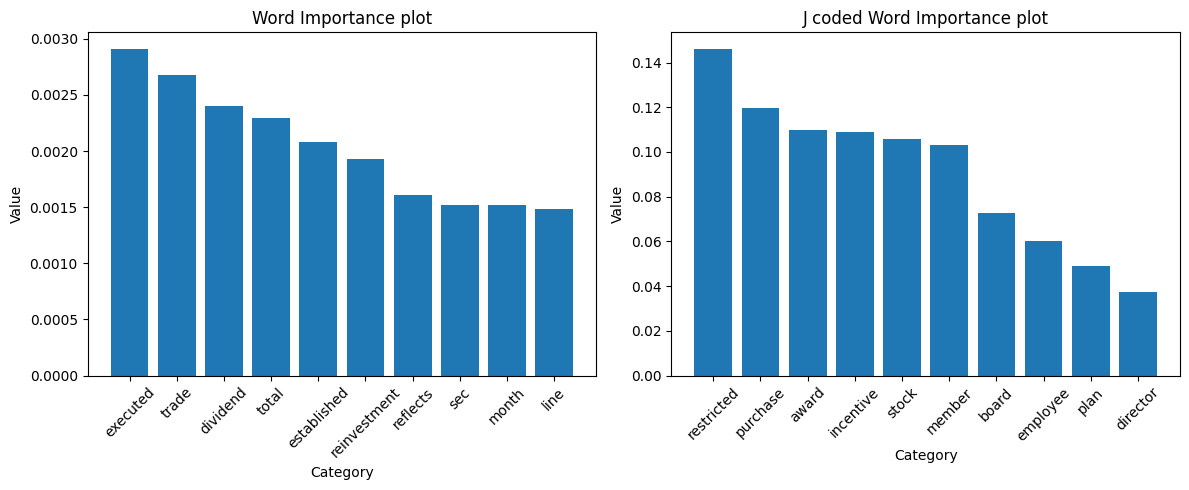

In [23]:
# Top 10 suspicious words Non-J coded and J coded
top_10_data = suspicious_words.head(10)
top_10_data_j = suspicious_words_j.head(10)

plt.figure(figsize=(12, 5))

########################
# Plot Non-J coded word importance
########################
plt.subplot(1, 2, 1)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Word Importance plot')
plt.bar(top_10_data.index, top_10_data.values)
plt.xticks(rotation=45)

########################
# Plot J coded word importance
########################
plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('J coded Word Importance plot')
plt.bar(top_10_data_j.index, top_10_data_j.values)

# Adjust layout and show
plt.tight_layout()
plt.show()


___
## Importance of features
___

### Feature creation:

In [32]:
def count_lemmatized(row, string):
    lemmatizer = WordNetLemmatizer()
    # print(row)
    words = word_tokenize(row.lower())
    counter = 0
    for word in words:
        if string == lemmatizer.lemmatize(word):
            counter += 1
    return counter

In [26]:
df_features

,ACCESSION_NUMBER,TRANS_CODE,TRANS_ACQUIRED_DISP_CD,anomaly_30,anomaly_60,anomaly_120,FOOTNOTE_TXT,label
0,0001127602-11-000075,S,D,-4.218320,-7.700075,-12.905019,The weighted average sales price was $41.652 w...,0
1,0001127602-11-002229,S,D,-4.035856,-7.005213,-11.027958,This transaction was effected pursuant to a Ru...,0
2,0001127602-11-003431,S,D,-3.801423,-5.029422,-7.327263,This transaction was effected pursuant to a Ru...,0
3,0001127602-11-004376,S,D,-3.574648,-5.308864,-9.187093,This transaction was effected pursuant to a Ru...,0
4,0001127602-11-005631,S,D,-3.416012,-4.854250,-8.289322,This transaction was effected pursuant to a Ru...,0
...,...,...,...,...,...,...,...,...
791678,0001104659-20-056286,S,D,-0.940465,-2.211733,-4.941855,Represents a restricted stock award issued pur...,0
791679,0001104659-20-056286,S,D,-0.940465,-2.211733,-4.941855,Represents a restricted stock award issued pur...,0
791680,0001104659-20-056286,S,D,-0.940465,-2.211733,-4.941855,Represents a restricted stock award issued pur...,0
791681,0001104659-20-056286,S,D,-1.054062,-2.285335,-5.040325,Represents a restricted stock award issued pur...,0


In [33]:
text_list = ["forced sale", "gift", "distribution", "charity", "10b5-1", "16b-3"]
text_from_keywords = ["executed", "trade", "dividend", "restricted"]
text_list.extend(text_from_keywords)
df_features = df_footnote_labels.copy()

for t in text_list:
    df_features[t] = df_features["FOOTNOTE_TXT"].apply(lambda row: count_lemmatized(row, t))
    
    # np.where(df_features["FOOTNOTE_TXT"].str.count(t), 1, 0)

text_list = text_list + ["anomaly_120", "label"]
df_features = df_features[text_list]
df_features.head()

,forced sale,gift,distribution,charity,10b5-1,16b-3,executed,trade,dividend,restricted,anomaly_120,label
0,0,0,0,0,0,0,0,0,0,0,-12.905019,0
1,0,0,0,0,1,1,0,0,0,0,-11.027958,0
2,0,0,0,0,1,0,0,0,0,0,-7.327263,0
3,0,0,0,0,1,1,0,0,0,0,-9.187093,0
4,0,0,0,0,1,1,0,0,0,0,-8.289322,0


In [59]:
df_features.to_csv("word_count.csv")

In [34]:
print(text_list)

['forced sale', 'gift', 'distribution', 'charity', '10b5-1', '16b-3', 'executed', 'trade', 'dividend', 'restricted', 'anomaly_120', 'label']


In [35]:
for col in df_features.columns:
    if col == "label" or col == "anomaly_120":
        continue
    print(f'{col}: {sum(df_features[col])}')

forced sale: 0
gift: 5472
distribution: 7687
charity: 217
10b5-1: 337430
16b-3: 20032
executed: 198020
trade: 196999
dividend: 80038
restricted: 243223


In [62]:
##################################
# Define functions
##################################

def compare_complement(df, col, metrics):
    split_1 = df[df[col] >= 1]
    split_2 = df[df[col] < 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col} is separated\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col} = {np.mean(A)}, mean {col} complement = {np.mean(B)}\n")
        
    print(f"{col}: n = {len(A)}, {col} complement: n = {len(B)}\n")

def compare_columns(df, col1, col2, metrics):
    split_1 = df[df[col1] == 1]
    split_2 = df[df[col2] == 1]
    
    for metric in metrics:
        A = split_1[metric].dropna()
        
        # print(A)
        B = split_2[metric].dropna()
        t_stat, p_val = stats.ttest_ind(A, B, equal_var=False)
        sign = "negative" if t_stat < 0 else "positive"
        print(f"{metric}: is more {sign} when {col1} compared to {col2}\n" 
              f"t-statistic = {t_stat}, p-value = {p_val}\n"
              f"mean {col1} = {np.mean(A)}, mean {col2} = {np.mean(B)}\n")
    print(f"{col1}: n = {len(A)}, {col2} : n = {len(B)}")

In [63]:
compare_complement(df_features,"executed", ["anomaly_120"])

anomaly_120: is more positive when executed is separated
t-statistic = 8.440625021767072, p-value = 3.2098523767567755e-17
mean executed = -4.664311242557403, mean executed complement = -8.227731884015604

executed: n = 61970, executed complement: n = 551944



In [64]:
compare_complement(df_features,"trade", ["anomaly_120"])

anomaly_120: is more positive when trade is separated
t-statistic = 0.26906833366102045, p-value = 0.7878778339198579
mean trade = -7.763570667004628, mean trade complement = -7.879517165242578

trade: n = 60815, trade complement: n = 553099



In [65]:
compare_complement(df_features,"dividend", ["anomaly_120"])

anomaly_120: is more negative when dividend is separated
t-statistic = -5.923079637844038, p-value = 3.1790579290093855e-09
mean dividend = -10.723522967663836, mean dividend complement = -7.6355618467173025

dividend: n = 46217, dividend complement: n = 567697



In [66]:
compare_complement(df_features,"restricted", ["anomaly_120"])

anomaly_120: is more positive when restricted is separated
t-statistic = 3.627353377935459, p-value = 0.0002864280242285236
mean restricted = -6.836232331219486, mean restricted complement = -8.10508858100237

restricted: n = 114696, restricted complement: n = 499218



In [67]:
compare_complement(df_features,"restricted", ["anomaly_120"])

anomaly_120: is more positive when restricted is separated
t-statistic = 3.627353377935459, p-value = 0.0002864280242285236
mean restricted = -6.836232331219486, mean restricted complement = -8.10508858100237

restricted: n = 114696, restricted complement: n = 499218



In [68]:
compare_complement(df_features, "forced sale", ["anomaly_120"])

anomaly_120: is more positive when forced sale is separated
t-statistic = nan, p-value = nan
mean forced sale = nan, mean forced sale complement = -7.8680313768579815

forced sale: n = 0, forced sale complement: n = 613914



In [69]:
compare_complement(df_features, "gift", ["anomaly_120"])

anomaly_120: is more positive when gift is separated
t-statistic = 3.8234216942935983, p-value = 0.00013332753344647336
mean gift = -3.2188461072825922, mean gift complement = -7.902845847311091

gift: n = 4563, gift complement: n = 609351



In [70]:
compare_complement(df_features, "distribution", ["anomaly_120"])

anomaly_120: is more positive when distribution is separated
t-statistic = 11.50059406974308, p-value = 3.230800323394858e-30
mean distribution = 7.764564343191978, mean distribution complement = -7.98974662840508

distribution: n = 4743, distribution complement: n = 609171



In [71]:
compare_complement(df_features, "charity", ["anomaly_120"])

anomaly_120: is more negative when charity is separated
t-statistic = -3.5796345399294367, p-value = 0.00043468022477177216
mean charity = -32.73998177472504, mean charity complement = -7.8601286879603185

charity: n = 195, charity complement: n = 613719



In [72]:
compare_complement(df_features, "10b5-1", ["anomaly_120"])

anomaly_120: is more negative when 10b5-1 is separated
t-statistic = -41.12055170934168, p-value = 0.0
mean 10b5-1 = -13.547889668811667, mean 10b5-1 complement = -2.7879070620388045

10b5-1: n = 289848, 10b5-1 complement: n = 324066



In [73]:
compare_complement(df_features, "16b-3", ["anomaly_120"])

anomaly_120: is more positive when 16b-3 is separated
t-statistic = 20.874907323376345, p-value = 1.631257520389304e-95
mean 16b-3 = 7.084987081650538, mean 16b-3 complement = -8.246681746072461

16b-3: n = 15162, 16b-3 complement: n = 598752



## Train test split on binary labels

In [74]:
labels = ["label"]

In [75]:
df_log = df_features.drop(columns=["anomaly_120"])
df_log = df_log.dropna(subset=labels)
X, y = df_log.drop(columns=labels), df_log[labels]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(f"train size x: {train_x.shape}\ntrain size y: {train_y.shape}\ntest size x: {test_x.shape}\ntest size y: {test_y.shape}")

train size x: (506519, 10)
train size y: (506519, 1)
test size x: (126630, 10)
test size y: (126630, 1)


## Fit log regression on labels

In [76]:
model = LogisticRegression()
result = model.fit(train_x, train_y)
y_pred = model.predict(test_x)

In [77]:
for i in range(len(model.feature_names_in_)):
    col = model.feature_names_in_[i]
    beta = model.coef_[0][i]
    print(f"{col}: {beta}")

forced sale: 0.0
gift: -0.1614801279140987
distribution: -0.05048799245667638
charity: -0.6575076123015473
10b5-1: -0.15148789095567838
16b-3: -0.04118235503327275
executed: 0.0644857472029892
trade: -0.08065765454230464
dividend: -0.035487784700091715
restricted: 0.038668165902048426


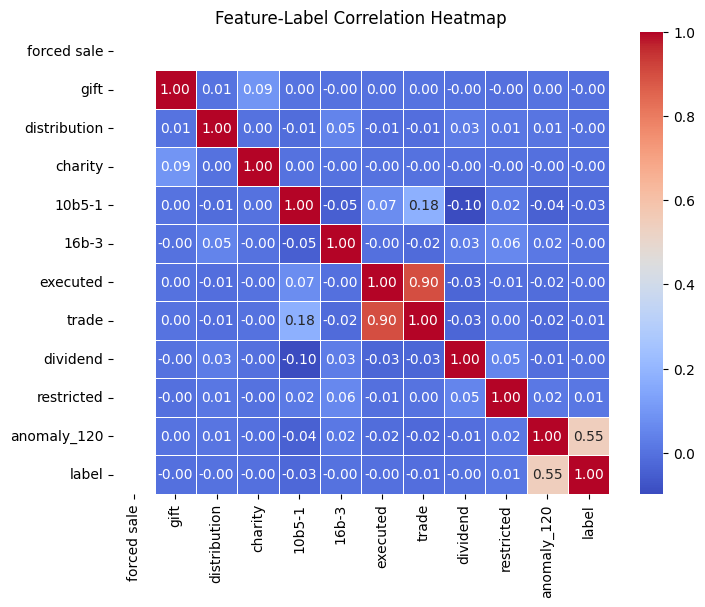

In [78]:
corr = df_features.corr(method="pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()

___
## Fit Regression on labels
___

In [79]:
temp = df_features.dropna(subset = ["anomaly_120"])
X, y = temp.drop(columns=["label", "anomaly_120"]), temp["anomaly_120"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(f"train size x: {train_x.shape}\ntrain size y: {train_y.shape}\ntest size x: {test_x.shape}\ntest size y: {test_y.shape}")

train size x: (491131, 10)
train size y: (491131,)
test size x: (122783, 10)
test size y: (122783,)


In [80]:
model1 = LinearRegression()
result = model1.fit(train_x, train_y)
y_pred = model1.predict(test_x)

In [91]:
temp = df_features.dropna(subset=["anomaly_120"])
X, y = temp.drop(columns=["label", "anomaly_120"]), temp["anomaly_120"]

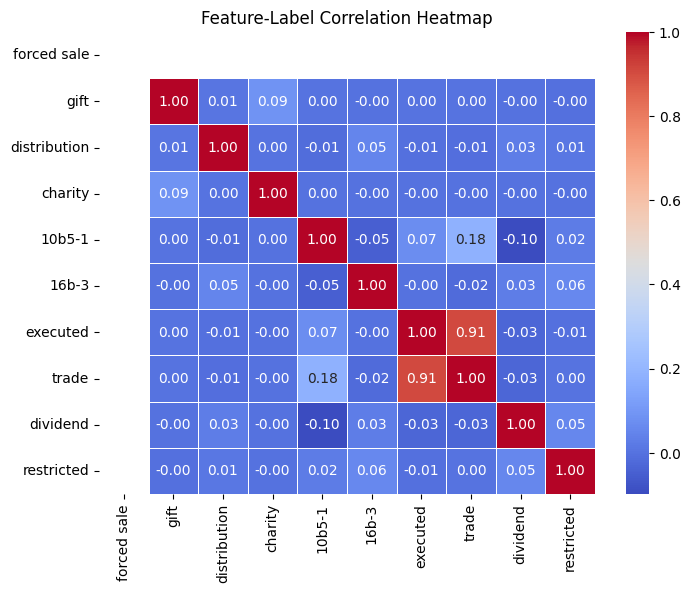

In [92]:
corr_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()


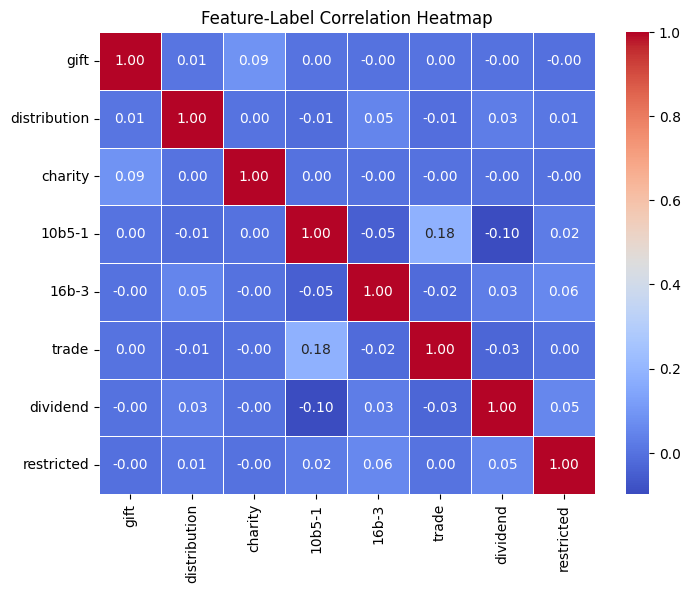

In [93]:
X = X.drop(columns=["executed", "forced sale"])
corr_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature-Label Correlation Heatmap")
plt.show()

In [94]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(f"train size x: {train_x.shape}\ntrain size y: {train_y.shape}\ntest size x: {test_x.shape}\ntest size y: {test_y.shape}")

train size x: (491131, 8)
train size y: (491131,)
test size x: (122783, 8)
test size y: (122783,)


In [95]:
import statsmodels.api as sm
import numpy as np

# Example Data (same as before)
# Feature (independent variable)
y =  train_y   # Target (dependent variable)
X = train_x
# Add a constant (intercept) term to the feature matrix
X_with_const = sm.add_constant(X)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_with_const)
results = model.fit()

# Print the summary of the model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            anomaly_120   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     167.6
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          9.32e-284
Time:                        09:14:55   Log-Likelihood:            -2.9696e+06
No. Observations:              491131   AIC:                         5.939e+06
Df Residuals:                  491122   BIC:                         5.939e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.2423      0.190    -27.608   

In [97]:
y =  train_y * 100   # Target (dependent variable)
X = train_x
# Add a constant (intercept) term to the feature matrix
X_with_const = sm.add_constant(X)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_with_const)
results = model.fit()

# Print the summary of the model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            anomaly_120   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     167.6
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          9.32e-284
Time:                        09:17:28   Log-Likelihood:            -5.2314e+06
No. Observations:              491131   AIC:                         1.046e+07
Df Residuals:                  491122   BIC:                         1.046e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -524.2254     18.988    -27.608   